# Leiden Clustering Analysis on BRCA Dataset

We're testing the Leiden community detection algorithm on breast cancer data from TCGA. The main question: can we find biologically meaningful groups of genes by clustering on a feature-feature similarity graph? We'll compare standard Leiden with a hybrid version that adds KMeans refinement to see which works better.

## Additional implementation of spectral clustering

## Goal:
The goal is to see whether these clusters match known breast cancer subtypes and marker genes, and whether the refined clusters are easier to interpret than plain Leiden
## Conclusion:
- Overall, Leiden class behaves reasonably on the BRCA feature graph and recovers modules that align with known PAM50 biology. Pure Leiden finds a few very large moduyle that already separate certain groups. 
- The hybrid Leiden+KMeans version breaks these into smaller, more focused groups that are tighter in embedding space. 
- Several of these refined modules show strong differences across PAM50 subtypes. This may suggest they capture meaningful subtype-specific patterns. 
- This notebook provides a concrete example that the new Leiden class and its refinement step might produce biologically interpretable clusters on a real multi-omics dataset.

### Step 1: Load data and build the feature graph

Starting with TCGA breast cancer data: RNA expression, miRNA, methylation, and PAM50 subtypes. Since we have thousands of features, we'll keep only the top 1000 most variable genes from RNA and methylation to focus on the informative ones.

After merging everything into one big table (patients as rows, features as columns), we build a k-nearest neighbor graph where each feature connects to its 15 most similar neighbors using cosine distance. This graph captures which genes have similar expression patterns across patients.

In [4]:
#!pip install pandas networkx bioneuralnet
#!pip install torch torch_geometric
import pandas as pd
import numpy as np
from bioneuralnet.datasets import DatasetLoader
from bioneuralnet.utils import select_top_k_variance
from bioneuralnet.utils.graph import gen_similarity_graph
import networkx as nx
from bioneuralnet.datasets import DatasetLoader

brca = DatasetLoader("brca")
print(f"{brca.shape}")
base_dir = brca.base_dir
rna = brca.data["rna"]
mirna = brca.data["mirna"]
meth = brca.data["meth"]
pam50 = brca.data["target"]

# Feature selection
rna_sel = select_top_k_variance(rna,  k=1000)
meth_sel = select_top_k_variance(meth, k=1000)
mirna_sel = mirna

# Merge omics along columns (patients x features)
merged_brca = pd.concat([rna_sel, meth_sel, mirna_sel], axis=1)
print("merged_brca shape:", merged_brca.shape)  # (N_patients, 2503 features)

# Build cosine kNN feature graph (features x features)
A_feature = gen_similarity_graph(
    merged_brca,
    k=15,
    metric="cosine",
    mutual=True,
    self_loops=False
)
print("A_feature shape:", A_feature.shape)



{'mirna': (769, 503), 'target': (769, 1), 'clinical': (769, 103), 'rna': (769, 2500), 'meth': (769, 2203)}


2025-12-02 21:53:01,509 - bioneuralnet.utils.preprocess - INFO - [Inf]: Replaced 0 infinite values
2025-12-02 21:53:01,509 - bioneuralnet.utils.preprocess - INFO - [NaN]: Replaced 0 NaNs after median imputation
2025-12-02 21:53:01,510 - bioneuralnet.utils.preprocess - INFO - [Zero-Var]: 0 columns dropped due to zero variance
2025-12-02 21:53:01,509 - bioneuralnet.utils.preprocess - INFO - [NaN]: Replaced 0 NaNs after median imputation
2025-12-02 21:53:01,510 - bioneuralnet.utils.preprocess - INFO - [Zero-Var]: 0 columns dropped due to zero variance
2025-12-02 21:53:01,538 - bioneuralnet.utils.preprocess - INFO - Selected top 1000 features by variance
2025-12-02 21:53:01,538 - bioneuralnet.utils.preprocess - INFO - Selected top 1000 features by variance
2025-12-02 21:53:02,080 - bioneuralnet.utils.preprocess - INFO - [Inf]: Replaced 0 infinite values
2025-12-02 21:53:02,082 - bioneuralnet.utils.preprocess - INFO - [NaN]: Replaced 0 NaNs after median imputation
2025-12-02 21:53:02,082 - 

merged_brca shape: (769, 2503)
A_feature shape: (2503, 2503)
A_feature shape: (2503, 2503)


### Step 3: Convert adjacency matrix to NetworkX format

The `adjacency_to_nx()` function takes our similarity matrix and converts it to a NetworkX graph object. We only keep the upper triangle to avoid counting each edge twice, and we store the similarity scores as edge weights so Leiden can use them during clustering.

In [5]:
def adjacency_to_nx(A, weight_threshold=0.0) -> nx.Graph:
    G = nx.Graph()
    nodes = list(A.index)  # feature names
    G.add_nodes_from(nodes)

    M = A.values
    rows, cols = np.nonzero(M)

    for i, j in zip(rows, cols):
        if i >= j:
            continue  # avoid duplicates / self-loops
        w = float(M[i, j])
        if w <= weight_threshold:
            continue
        u = nodes[i]
        v = nodes[j]
        G.add_edge(u, v, weight=w)

    return G

G_feature = adjacency_to_nx(A_feature, weight_threshold=0.0)
print(f"Graph: {G_feature.number_of_nodes()} nodes, {G_feature.number_of_edges()} edges")


Graph: 2503 nodes, 2734 edges


### Step 5: Train GNN to create feature embeddings

Now we train a graph neural network to learn compact representations of each feature. The GNN looks at both the graph structure (which genes connect to which) and the actual expression data. We also feed in the PAM50 labels to help guide the learning.

We're skipping hyperparameter tuning here to keep things fast. The output is a low-dimensional embedding for each gene that we'll use later in the hybrid clustering approach.

In [6]:
from bioneuralnet.network_embedding import GNNEmbedding

print("adjacency shape:", A_feature.shape)    # (2503, 2503)
print("omics_data shape:", merged_brca.shape) # (769, 2503)
print("pam50 shape:", pam50.shape, type(pam50))

# Just in case pam50 got converted to something weird
if not isinstance(pam50, (pd.Series, pd.DataFrame)):
    pam50 = pd.DataFrame(pam50)

# make it a single-column DF
if isinstance(pam50, pd.Series):
    pam50 = pam50.to_frame(name="pam50")

phenotype_col = pam50.columns[0]   # name of the single phenotype column

gnn = GNNEmbedding(
    adjacency_matrix=A_feature,
    omics_data=merged_brca,# N x D
    phenotype_data=pam50, # N x 1
    clinical_data=None, # drop clinical to avoid string issues
    phenotype_col=phenotype_col,
    tune=False,
    gpu=False,
)

gnn.fit()
emb_df = gnn.embed(as_df=True)
print("emb_df shape:", emb_df.shape)
print(emb_df.head())



2025-12-02 21:53:07,160 - bioneuralnet.network_embedding.gnn_embedding - INFO - Initialized GNNEmbedding. device=cpu
2025-12-02 21:53:07,161 - bioneuralnet.network_embedding.gnn_embedding - INFO - No output_dir provided; using temporary directory: C:\Users\Hiro\AppData\Local\Temp\tmpbqbxozfs
2025-12-02 21:53:07,162 - bioneuralnet.network_embedding.gnn_embedding - INFO - Starting training process.
2025-12-02 21:53:07,162 - bioneuralnet.network_embedding.gnn_embedding - INFO - Preparing node features.
2025-12-02 21:53:07,163 - bioneuralnet.network_embedding.gnn_embedding - INFO - Found 2503 common features between network and omics data.
2025-12-02 21:53:07,161 - bioneuralnet.network_embedding.gnn_embedding - INFO - No output_dir provided; using temporary directory: C:\Users\Hiro\AppData\Local\Temp\tmpbqbxozfs
2025-12-02 21:53:07,162 - bioneuralnet.network_embedding.gnn_embedding - INFO - Starting training process.
2025-12-02 21:53:07,162 - bioneuralnet.network_embedding.gnn_embedding - 

adjacency shape: (2503, 2503)
omics_data shape: (769, 2503)
pam50 shape: (769, 1) <class 'pandas.core.frame.DataFrame'>


2025-12-02 21:53:07,578 - bioneuralnet.network_embedding.gnn_embedding - WARNING - Eigenvector centrality failed for component size 42; defaulting to 0.
2025-12-02 21:53:07,806 - bioneuralnet.network_embedding.gnn_embedding - WARNING - Eigenvector centrality failed for component size 225; defaulting to 0.
2025-12-02 21:53:07,806 - bioneuralnet.network_embedding.gnn_embedding - WARNING - Eigenvector centrality failed for component size 225; defaulting to 0.
2025-12-02 21:53:07,875 - bioneuralnet.network_embedding.gnn_embedding - WARNING - Eigenvector centrality failed for component size 111; defaulting to 0.
2025-12-02 21:53:07,875 - bioneuralnet.network_embedding.gnn_embedding - WARNING - Eigenvector centrality failed for component size 111; defaulting to 0.
2025-12-02 21:53:07,912 - bioneuralnet.network_embedding.gnn_embedding - WARNING - Eigenvector centrality failed for component size 69; defaulting to 0.
2025-12-02 21:53:07,912 - bioneuralnet.network_embedding.gnn_embedding - WARNI

emb_df shape: (2503, 64)
               Embed_1   Embed_2   Embed_3  ...  Embed_62  Embed_63  Embed_64
CPB1_1360     0.011181  0.000000  0.117911  ...  0.000000  0.164974  0.045566
TFF1_7031     0.134288  0.000000  0.306667  ...  0.000000  0.273300  0.000000
MUCL1_118430  0.000000  0.698607  0.000000  ...  0.138864  0.000000  0.668298
PRAME_23532   0.000000  0.658206  0.000000  ...  0.191346  0.000000  0.714208
KCNJ3_3760    0.000000  0.210418  0.000000  ...  0.054719  0.000000  0.193041

[5 rows x 64 columns]


### Step 6: Do the embeddings match the graph

Before going further, make sure the graph nodes and embedding rows are actually talking about the same features. We'll print out a few names from each and check if anything's missing. Better to catch any mismatches now than debug weird clustering results later.

In [7]:
nodes = list(G_feature.nodes())
print("First 5 graph nodes:", nodes[:5])

print("First 5 emb_df index:", emb_df.index[:5])

missing_in_emb = set(nodes) - set(emb_df.index)
missing_in_graph = set(emb_df.index) - set(nodes)

print("Missing in embeddings:", len(missing_in_emb))
print("Missing in graph:", len(missing_in_graph))


First 5 graph nodes: ['CPB1_1360', 'TFF1_7031', 'MUCL1_118430', 'PRAME_23532', 'KCNJ3_3760']
First 5 emb_df index: Index(['CPB1_1360', 'TFF1_7031', 'MUCL1_118430', 'PRAME_23532', 'KCNJ3_3760'], dtype='object')
Missing in embeddings: 0
Missing in graph: 0


### Step 7: Reorder embeddings to match graph

Make sure the embedding rows are in the exact same order as the graph nodes. This way when Leiden assigns cluster 0 to node 5, we know exactly which gene that refers to. 
Convert to numpy array while we're at it for faster processing.

In [8]:
emb_aligned = emb_df.loc[nodes].to_numpy()
print("emb_aligned shape:", emb_aligned.shape)


emb_aligned shape: (2503, 64)


### Step 8: Try different graph construction parameters

The graph we build affects the clusters we get. We try a few variations: different values of k (how many neighbors each feature connects to) and whether edges must be mutual (both features consider each other neighbors). We'll store all these graphs to compare them systematically in the next section.

## Exploring how graph construction choices affect clustering

In [9]:
def build_graph(k, mutual):
    A = gen_similarity_graph(
        merged_brca,
        k=k,
        metric="cosine",
        mutual=mutual,
        self_loops=False,
    )
    G = adjacency_to_nx(A, weight_threshold=0.0)
    print(f"[k={k}, mutual={mutual}] graph: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges")
    return A, G

configs = [
    (15, True),
    (20, True),
    (25, True),
    (20, False),
    (25, False),
]

graphs = {}
for k, mut in configs:
    A_k, G_k = build_graph(k, mut)
    graphs[(k, mut)] = (A_k, G_k)


[k=15, mutual=True] graph: 2503 nodes, 2734 edges
[k=20, mutual=True] graph: 2503 nodes, 3845 edges
[k=20, mutual=True] graph: 2503 nodes, 3845 edges
[k=25, mutual=True] graph: 2503 nodes, 4985 edges
[k=25, mutual=True] graph: 2503 nodes, 4985 edges
[k=20, mutual=False] graph: 2503 nodes, 28246 edges
[k=20, mutual=False] graph: 2503 nodes, 28246 edges
[k=25, mutual=False] graph: 2503 nodes, 35494 edges
[k=25, mutual=False] graph: 2503 nodes, 35494 edges


### Step 9: Quick summary function for cluster sizes

Helper counts how many clusters we got and shows their size distribution. Are we getting a few giant clusters or many small ones? The top 10 sizes tell us if there are any dominant communities worth investigating.

In [10]:
def summarize_clusters(labels, name):
    unique, counts = np.unique(labels, return_counts=True)
    sizes = pd.Series(counts)
    print(f"{name}: {len(unique)} clusters")
    print("  size stats:", sizes.describe())
    print("  top 10 largest sizes:", sizes.sort_values(ascending=False).head(10).tolist())


## Scan across different graph constructions and resolution values for Leiden

Time to run a small grid search. For each graph we built, we'll try Leiden at several resolution values. Resolution is like a zoom level: high resolution finds many small clusters, low resolution finds fewer big ones.

We'll look at how many clusters we get, their sizes, and the modularity score (higher = better separated communities). This helps us pick good settings before diving into the biology.

In [11]:
try:
    # When bioneuralnet package includes leiden_upd
    from bioneuralnet.clustering.leiden_upd import Leiden_upd
except ModuleNotFoundError:
    # Fallback when running notebook from inside bioneuralnet/clustering
    from leiden_upd import Leiden_upd
resolutions = [1.0, 0.5, 0.25, 0.1]

for (k, mut), (A_k, G_k) in graphs.items():
    print("="*70)
    print(f"Graph config: k={k}, mutual={mut}")
    nodes_k = list(G_k.nodes())
    emb_k = emb_df.loc[nodes_k].to_numpy()

    for res in resolutions:
        print(f"  -- resolution={res} --")
        lc = Leiden_upd(
            G=G_k,
            embeddings=emb_k,
            use_edge_weights=True,
            resolution=res,
            random_state=0,
        )
        labels_leiden = lc.run(refine_with_kmeans=False)
        summarize_clusters(labels_leiden, f"Leiden(k={k},mutual={mut},res={res})")
        print(f"  quality={lc.modularity_:.3f}")


2025-12-02 21:53:37,767 - leiden_upd - INFO - Built igraph from NetworkX: 2503 nodes, 2734 edges, directed=False, use_edge_weights=True, weights_effective=yes.
2025-12-02 21:53:37,779 - leiden_upd - INFO - Leiden found 1362 communities on 2503 nodes (resolution=1.0).
2025-12-02 21:53:37,779 - leiden_upd - INFO - Leiden found 1362 communities on 2503 nodes (resolution=1.0).
2025-12-02 21:53:37,785 - leiden_upd - INFO - Built igraph from NetworkX: 2503 nodes, 2734 edges, directed=False, use_edge_weights=True, weights_effective=yes.
2025-12-02 21:53:37,785 - leiden_upd - INFO - Built igraph from NetworkX: 2503 nodes, 2734 edges, directed=False, use_edge_weights=True, weights_effective=yes.
2025-12-02 21:53:37,798 - leiden_upd - INFO - Leiden found 1355 communities on 2503 nodes (resolution=0.5).
2025-12-02 21:53:37,803 - leiden_upd - INFO - Built igraph from NetworkX: 2503 nodes, 2734 edges, directed=False, use_edge_weights=True, weights_effective=yes.
2025-12-02 21:53:37,798 - leiden_upd

Graph config: k=15, mutual=True
  -- resolution=1.0 --
Leiden(k=15,mutual=True,res=1.0): 1362 clusters
  size stats: count    1362.000000
mean        1.837739
std         5.378894
min         1.000000
25%         1.000000
50%         1.000000
75%         1.000000
max        82.000000
dtype: float64
  top 10 largest sizes: [82, 72, 56, 53, 50, 50, 46, 45, 42, 41]
  quality=1205.422
  -- resolution=0.5 --
Leiden(k=15,mutual=True,res=0.5): 1355 clusters
  size stats: count    1355.000000
mean        1.847232
std         6.004760
min         1.000000
25%         1.000000
50%         1.000000
75%         1.000000
max        89.000000
dtype: float64
  top 10 largest sizes: [89, 72, 68, 67, 66, 66, 53, 50, 46, 45]
  quality=1223.289
  -- resolution=0.25 --
Leiden(k=15,mutual=True,res=0.25): 1351 clusters
  size stats: count    1351.000000
mean        1.852702
std         6.776959
min         1.000000
25%         1.000000
50%         1.000000
75%         1.000000
max       129.000000
dtype: fl

2025-12-02 21:53:37,949 - leiden_upd - INFO - Built igraph from NetworkX: 2503 nodes, 4985 edges, directed=False, use_edge_weights=True, weights_effective=yes.
2025-12-02 21:53:37,961 - leiden_upd - INFO - Leiden found 1109 communities on 2503 nodes (resolution=0.5).
2025-12-02 21:53:37,969 - leiden_upd - INFO - Built igraph from NetworkX: 2503 nodes, 4985 edges, directed=False, use_edge_weights=True, weights_effective=yes.
2025-12-02 21:53:37,961 - leiden_upd - INFO - Leiden found 1109 communities on 2503 nodes (resolution=0.5).
2025-12-02 21:53:37,969 - leiden_upd - INFO - Built igraph from NetworkX: 2503 nodes, 4985 edges, directed=False, use_edge_weights=True, weights_effective=yes.
2025-12-02 21:53:37,983 - leiden_upd - INFO - Leiden found 1102 communities on 2503 nodes (resolution=0.25).
2025-12-02 21:53:37,991 - leiden_upd - INFO - Built igraph from NetworkX: 2503 nodes, 4985 edges, directed=False, use_edge_weights=True, weights_effective=yes.
2025-12-02 21:53:37,983 - leiden_up

Leiden(k=25,mutual=True,res=0.5): 1109 clusters
  size stats: count    1109.000000
mean        2.256988
std         9.174686
min         1.000000
25%         1.000000
50%         1.000000
75%         1.000000
max       158.000000
dtype: float64
  top 10 largest sizes: [158, 104, 101, 92, 87, 67, 66, 64, 63, 55]
  quality=1402.758
  -- resolution=0.25 --
Leiden(k=25,mutual=True,res=0.25): 1102 clusters
  size stats: count    1102.000000
mean        2.271325
std        10.405401
min         1.000000
25%         1.000000
50%         1.000000
75%         1.000000
max       158.000000
dtype: float64
  top 10 largest sizes: [158, 139, 107, 105, 104, 100, 99, 92, 66, 63]
  quality=1420.461
  -- resolution=0.1 --
Leiden(k=25,mutual=True,res=0.1): 1096 clusters
  size stats: count    1096.000000
mean        2.283759
std        12.784864
min         1.000000
25%         1.000000
50%         1.000000
75%         1.000000
max       263.000000
dtype: float64
  top 10 largest sizes: [263, 142, 139, 

2025-12-02 21:53:38,173 - leiden_upd - INFO - Built igraph from NetworkX: 2503 nodes, 28246 edges, directed=False, use_edge_weights=True, weights_effective=yes.
2025-12-02 21:53:38,191 - leiden_upd - INFO - Leiden found 14 communities on 2503 nodes (resolution=0.1).
2025-12-02 21:53:38,191 - leiden_upd - INFO - Leiden found 14 communities on 2503 nodes (resolution=0.1).
2025-12-02 21:53:38,228 - leiden_upd - INFO - Built igraph from NetworkX: 2503 nodes, 35494 edges, directed=False, use_edge_weights=True, weights_effective=yes.
2025-12-02 21:53:38,228 - leiden_upd - INFO - Built igraph from NetworkX: 2503 nodes, 35494 edges, directed=False, use_edge_weights=True, weights_effective=yes.
2025-12-02 21:53:38,247 - leiden_upd - INFO - Leiden found 17 communities on 2503 nodes (resolution=1.0).
2025-12-02 21:53:38,247 - leiden_upd - INFO - Leiden found 17 communities on 2503 nodes (resolution=1.0).
2025-12-02 21:53:38,282 - leiden_upd - INFO - Built igraph from NetworkX: 2503 nodes, 35494 e

Leiden(k=20,mutual=False,res=0.1): 14 clusters
  size stats: count      14.000000
mean      178.785714
std       434.059404
min         1.000000
25%         1.000000
50%         1.000000
75%       120.250000
max      1615.000000
dtype: float64
  top 10 largest sizes: [1615, 410, 308, 160, 1, 1, 1, 1, 1, 1]
  quality=2631.901
Graph config: k=25, mutual=False
  -- resolution=1.0 --
Leiden(k=25,mutual=False,res=1.0): 17 clusters
  size stats: count     17.000000
mean     147.235294
std      155.434685
min        1.000000
25%        1.000000
50%      131.000000
75%      301.000000
max      461.000000
dtype: float64
  top 10 largest sizes: [461, 350, 348, 320, 301, 164, 163, 161, 131, 97]
  quality=2144.922
  -- resolution=0.5 --
Leiden(k=25,mutual=False,res=0.5): 15 clusters
  size stats: count     15.000000
mean     166.866667
std      202.299589
min        1.000000
25%        1.000000
50%       93.000000
75%      336.500000
max      632.000000
dtype: float64
  top 10 largest sizes: [632,

2025-12-02 21:53:38,392 - leiden_upd - INFO - Built igraph from NetworkX: 2503 nodes, 35494 edges, directed=False, use_edge_weights=True, weights_effective=yes.
2025-12-02 21:53:38,409 - leiden_upd - INFO - Leiden found 11 communities on 2503 nodes (resolution=0.1).
2025-12-02 21:53:38,409 - leiden_upd - INFO - Leiden found 11 communities on 2503 nodes (resolution=0.1).


Leiden(k=25,mutual=False,res=0.1): 11 clusters
  size stats: count      11.000000
mean      227.545455
std       389.151735
min         1.000000
25%         1.000000
50%         1.000000
75%       355.500000
max      1235.000000
dtype: float64
  top 10 largest sizes: [1235, 550, 397, 314, 1, 1, 1, 1, 1, 1]
  quality=2635.110


## Pick the best configuration and compare pure vs hybrid clustering

From the sweep above, k=25 with non-mutual edges and resolution=0.25 looks promising. Let's use that graph to compare two approaches:

1. **Pure Leiden**: Standard community detection, optimizes modularity
2. **Hybrid Leiden+KMeans**: Takes each Leiden community and optionally splits it further using KMeans on the embeddings

The hybrid version usually finds more clusters because it can break up large communities that might be mixing different biological signals.

In [12]:
# k=25, mutual=False, resolution=0.25
A_best, G_best = graphs[(25, False)]
nodes_best = list(G_best.nodes())
emb_best = emb_df.loc[nodes_best].to_numpy()

lc_best = Leiden_upd(
    G=G_best,
    embeddings=emb_best,
    use_edge_weights=True,
    resolution=0.25,
    random_state=0,
)

labels_leiden_best = lc_best.run(refine_with_kmeans=False)
labels_hybrid_best = lc_best.run(refine_with_kmeans=True, max_k_per_community=3)

print("Best pure Leiden communities:", len(set(labels_leiden_best)))
print("Best hybrid clusters:", len(set(labels_hybrid_best)))

summarize_clusters(labels_leiden_best, "Best Leiden")
summarize_clusters(labels_hybrid_best, "Best Hybrid")
print("Best Leiden quality:", lc_best.modularity_)


2025-12-02 21:53:43,782 - leiden_upd - INFO - Built igraph from NetworkX: 2503 nodes, 35494 edges, directed=False, use_edge_weights=True, weights_effective=yes.
2025-12-02 21:53:43,801 - leiden_upd - INFO - Leiden found 13 communities on 2503 nodes (resolution=0.25).
2025-12-02 21:53:43,801 - leiden_upd - INFO - Leiden found 13 communities on 2503 nodes (resolution=0.25).
2025-12-02 21:53:47,268 - leiden_upd - INFO - Hybrid Leiden+KMeans produced 25 clusters (base communities: 13).
2025-12-02 21:53:47,268 - leiden_upd - INFO - Hybrid Leiden+KMeans produced 25 clusters (base communities: 13).


Best pure Leiden communities: 13
Best hybrid clusters: 25
Best Leiden: 13 clusters
  size stats: count     13.000000
mean     192.538462
std      239.949167
min        1.000000
25%        1.000000
50%        1.000000
75%      333.000000
max      745.000000
dtype: float64
  top 10 largest sizes: [745, 397, 375, 333, 326, 320, 1, 1, 1, 1]
Best Hybrid: 25 clusters
  size stats: count     25.000000
mean     100.120000
std       92.511405
min        1.000000
25%        1.000000
50%      101.000000
75%      155.000000
max      351.000000
dtype: float64
  top 10 largest sizes: [351, 288, 194, 191, 179, 156, 155, 116, 115, 114]
Best Leiden quality: 2497.6575080462226


### Step 10: Plot cluster sizes

Let's visualize how big each cluster is. The first plot shows pure Leiden (often a few very large clusters), the second shows the hybrid version (typically more clusters, more evenly sized). This gives us a quick sense of whether the refinement step is actually breaking things up.

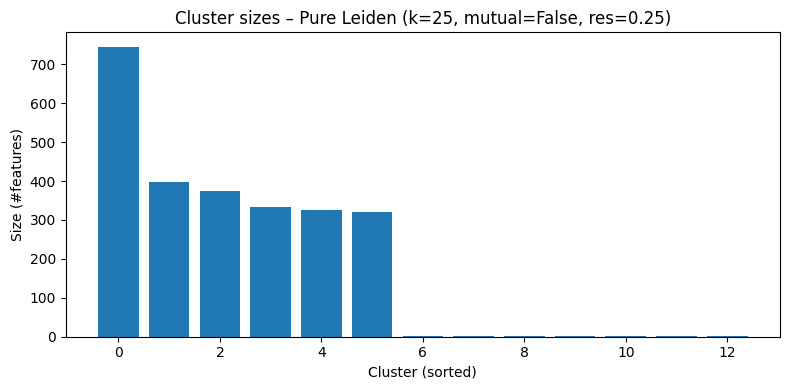

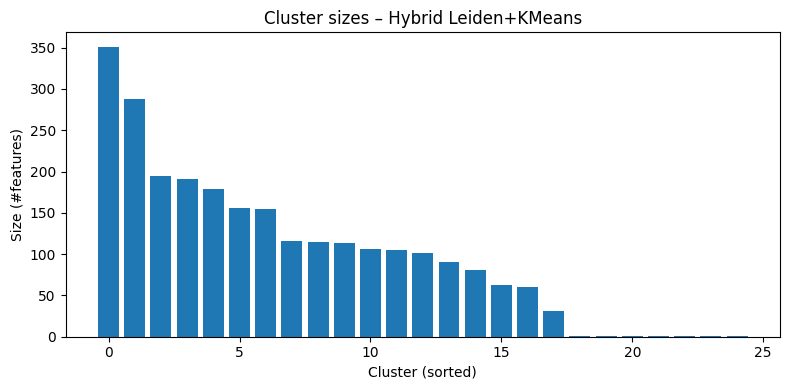

In [13]:
import matplotlib.pyplot as plt

def cluster_sizes(labels):
    _, counts = np.unique(labels, return_counts=True)
    return np.sort(counts)[::-1]

sizes_leiden = cluster_sizes(labels_leiden_best)
sizes_hybrid = cluster_sizes(labels_hybrid_best)


plt.figure(figsize=(8, 4))
plt.bar(np.arange(len(sizes_leiden)), sizes_leiden)
plt.xlabel("Cluster (sorted)")
plt.ylabel("Size (#features)")
plt.title("Cluster sizes – Pure Leiden (k=25, mutual=False, res=0.25)")
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 4))
plt.bar(np.arange(len(sizes_hybrid)), sizes_hybrid)
plt.xlabel("Cluster (sorted)")
plt.ylabel("Size (#features)")
plt.title("Cluster sizes – Hybrid Leiden+KMeans")
plt.tight_layout()
plt.show()


### Step 11: Squash embeddings down to 2D with UMAP

UMAP lets us take the high-dimensional GNN embeddings and project them onto a 2D plane while keeping similar points close together. This makes it easy to visualize whether our clusters actually form coherent groups in embedding space.

In [14]:
#!pip install umap-learn
from umap import UMAP

umap = UMAP(n_components=2, random_state=0)
emb_2d = umap.fit_transform(emb_best)


x, y = emb_2d[:, 0], emb_2d[:, 1]


c:\Users\Hiro\gnn1\BioNeuralNet\.venv\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


### Step 12: Visualize both clusterings in 2D space

Now we can see the clusters. Left plot: pure Leiden colors. Right plot: hybrid Leiden+KMeans colors. If the colors form distinct blobs, that's good - it means the clustering makes sense in embedding space. If colors are all mixed up, the clusters might not be very meaningful.

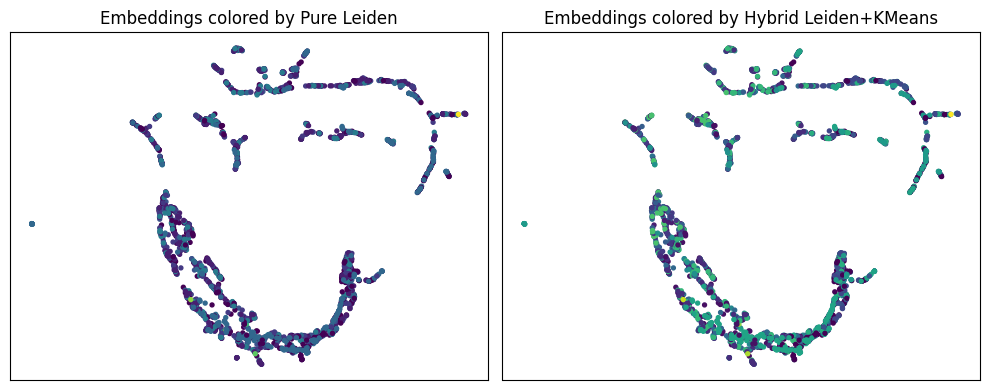

In [15]:
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.scatter(x, y, c=labels_leiden_best, s=8)
plt.title("Embeddings colored by Pure Leiden")
plt.xticks([]); plt.yticks([])

plt.subplot(1, 2, 2)
plt.scatter(x, y, c=labels_hybrid_best, s=8)
plt.title("Embeddings colored by Hybrid Leiden+KMeans")
plt.xticks([]); plt.yticks([])

plt.tight_layout()
plt.show()


## Visualize gene embeddings with  UMAP.
- Overall method is same but the hybrid method refines the large mixed communited produced by pure leiden into smaller more localized modules.

C:\Users\Hiro\AppData\Local\Temp\ipykernel_19156\3271991698.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  base_cmap = plt.cm.get_cmap("tab20", len(unique))


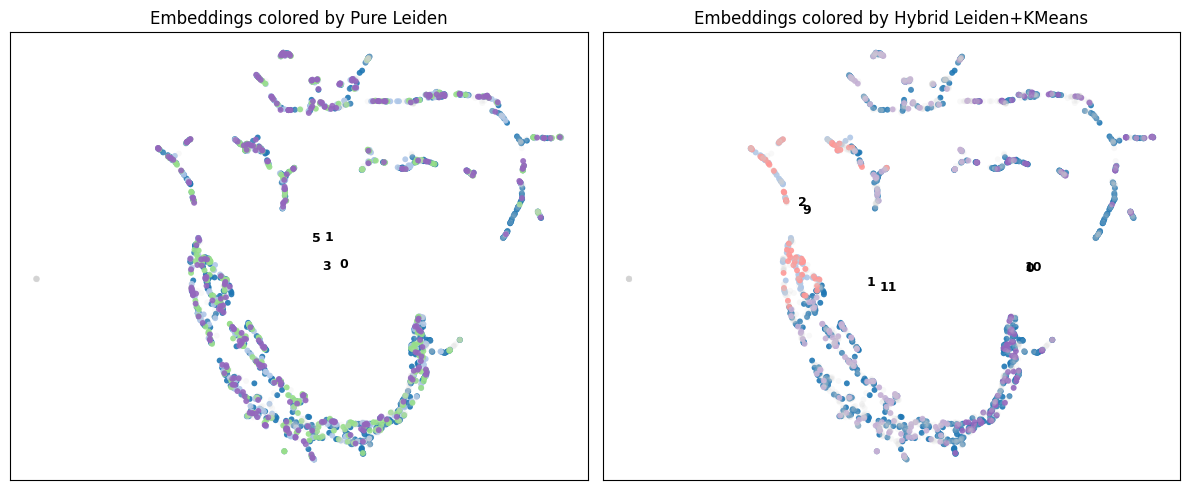

In [ ]:
def plot_umap_clusters(x, y, labels, title, highlight=None):
    """
    x, y      : 1D arrays with UMAP coordinates
    labels    : 1D array of cluster labels (ints)
    highlight : list/set of cluster IDs to emphasize (others will be grey)
    """
    x = np.asarray(x)
    y = np.asarray(y)
    labels = np.asarray(labels)

    if highlight is not None:
        highlight = set(highlight)

    unique = np.unique(labels)
    base_cmap = plt.cm.get_cmap("tab20", len(unique))

    for i, cid in enumerate(unique):
        mask = labels == cid

        # color + alpha depending on whether it's highlighted
        if highlight is None or cid in highlight:
            color = base_cmap(i % base_cmap.N)
            alpha = 0.9
        else:
            color = "lightgrey"
            alpha = 0.15

        plt.scatter(
            x[mask],
            y[mask],
            s=18,
            color=color,
            alpha=alpha,
            edgecolors="none",
        )

        # only label highlighted clusters
        if highlight is None or cid in highlight:
            cx, cy = x[mask].mean(), y[mask].mean()
            plt.text(cx, cy, str(cid), fontsize=9, weight="bold")

    plt.title(title)
    plt.xticks([]); plt.yticks([])

plt.figure(figsize=(12, 5))
pure_pam50_clusters = [0, 1, 3, 5]
hybrid_pam50_clusters = [0, 1, 2, 9, 10, 11]

plt.subplot(1, 2, 1)
plot_umap_clusters(
    x, y, labels_leiden_best,
    title="Embeddings colored by Pure Leiden",
    highlight=pure_pam50_clusters,
)

plt.subplot(1, 2, 2)
plot_umap_clusters(
    x, y, labels_hybrid_best,
    title="Embeddings colored by Hybrid Leiden+KMeans",
    highlight=hybrid_pam50_clusters,
)

plt.tight_layout()
plt.show()



## Check modularity scores

Modularity measures how well the clusters respect the graph structure. Basically: are there way more edges within clusters than between clusters? Higher is better.

Pure Leiden optimizes modularity directly, so it should score well. The hybrid method might score lower because it's also trying to respect the embedding space, not just the graph. That's okay - it's a trade-off.

In [17]:
from networkx.algorithms import community

def nx_modularity(G, labels):
    # labels: array of cluster IDs aligned with nodes_best
    clusters = {}
    for node, c in zip(nodes_best, labels):
        clusters.setdefault(c, []).append(node)
    communities = [set(v) for v in clusters.values()]
    return community.modularity(G, communities, weight="weight")

mod_pure = lc_best.modularity_
mod_hybrid = nx_modularity(G_best, labels_hybrid_best)

print("Graph modularity (pure Leiden):", mod_pure)
print("Graph modularity (hybrid):", mod_hybrid)


Graph modularity (pure Leiden): 2497.6575080462226
Graph modularity (hybrid): 0.29005765536208533


### Step 13: Double-check with NetworkX

Just to be safe, let's recalculate modularity using NetworkX's function directly. If the numbers match what Leiden reported, we're good. If not, something's wrong with how we're handling the clusters.

In [18]:
mod_pure_nx = nx_modularity(G_best, labels_leiden_best)
mod_hybrid_nx = nx_modularity(G_best, labels_hybrid_best)
print("NX modularity pure:", mod_pure_nx)
print("NX modularity hybrid:", mod_hybrid_nx)


NX modularity pure: 0.7228197243972823
NX modularity hybrid: 0.29005765536208533


## How tight are the clusters in embedding space?

Two metrics:
- **Silhouette score**: Do points stick close to their cluster and far from others? Higher is better (ranges -1 to 1).
- **Davies-Bouldin index**: Ratio of within-cluster spread to between-cluster separation. Lower is better.

We'll filter out tiny clusters (< 2 members) to avoid division by zero. These metrics tell us if the clusters make sense geometrically, complementing the graph-based modularity measure.

In [19]:
from sklearn.metrics import silhouette_score, davies_bouldin_score

def filter_small_clusters(X, labels, min_size=2):
    labels = np.asarray(labels)
    X = np.asarray(X)
    _, counts = np.unique(labels, return_counts=True)
    big_clusters = {c for c, cnt in zip(*np.unique(labels, return_counts=True)) 
                    if cnt >= min_size}
    mask = np.array([l in big_clusters for l in labels])
    return X[mask], labels[mask]

# Embedding space
X_emb = emb_best

X_pure,   lab_pure = filter_small_clusters(X_emb, labels_leiden_best, min_size=2)
X_hybrid, lab_hybrid = filter_small_clusters(X_emb, labels_hybrid_best, min_size=2)

sil_pure = silhouette_score(X_pure, lab_pure)
sil_hybrid = silhouette_score(X_hybrid, lab_hybrid)

db_pure = davies_bouldin_score(X_pure, lab_pure)
db_hybrid = davies_bouldin_score(X_hybrid, lab_hybrid)

print("Silhouette (embedding) pure:",   sil_pure)
print("Silhouette (embedding) hybrid:", sil_hybrid)
print("Davies–Bouldin (embedding) pure:",   db_pure)
print("Davies–Bouldin (embedding) hybrid:", db_hybrid)


Silhouette (embedding) pure: -0.10731714218854904
Silhouette (embedding) hybrid: -0.10521171987056732
Davies–Bouldin (embedding) pure: 30.54262907217618
Davies–Bouldin (embedding) hybrid: 13.658046290024451


## Do clusters group genes with similar expression?

So far we've looked at cluster quality in the learned embedding space. But what about the original expression data? Let's compute silhouette score using raw expression profiles (genes × patients). If it's high, our clusters are grouping genes that actually behave similarly across patients - a good biological sign.

In [20]:
# Expression-space representations for features
X_expr = merged_brca.T.loc[nodes_best].to_numpy() # features x patients

X_pure_expr, lab_pure_expr = filter_small_clusters(X_expr, labels_leiden_best)
X_hybrid_expr, lab_hybrid_expr = filter_small_clusters(X_expr, labels_hybrid_best)

sil_pure_expr = silhouette_score(X_pure_expr, lab_pure_expr)
sil_hybrid_expr = silhouette_score(X_hybrid_expr, lab_hybrid_expr)

print("Silhouette (expression) – pure:",   sil_pure_expr)
print("Silhouette (expression) – hybrid:", sil_hybrid_expr)


Silhouette (expression) – pure: 0.04171223979236798
Silhouette (expression) – hybrid: -0.10293700538128935


## Do these clusters relate to known breast cancer subtypes?

Here's where we see if the clustering found anything biologically meaningful. For each cluster, we'll:
1. Calculate a "module eigengene" - basically the main expression pattern of that cluster across all patients
2. Test whether this pattern differs significantly across PAM50 subtypes (Luminal A, Luminal B, Basal, Her2, Normal) using ANOVA

Clusters with low p-values are the interesting ones - they capture expression patterns that distinguish cancer subtypes. We only look at clusters with 5+ genes to keep the statistics stable.

In [26]:
from sklearn.decomposition import PCA
import scipy.stats as stats

# Make a DataFrame of labels aligned with features
cluster_df = pd.DataFrame({
    "feature": nodes_best,
    "cluster_hybrid": labels_hybrid_best,
})
cluster_df.set_index("feature", inplace=True)

subtypes = pam50.iloc[:, 0] # "LumA", "LumB", etc.

def module_eigengene(features):
    # features: list of feature names
    X = merged_brca[features]
    # center features
    X_centered = X - X.mean(axis=0)
    pca = PCA(n_components=1)
    eig = pca.fit_transform(X_centered)[:, 0]  # (patients,)
    return pd.Series(eig, index=merged_brca.index)

results = []

for c_id in sorted(cluster_df["cluster_hybrid"].unique()):
    feats = cluster_df.index[cluster_df["cluster_hybrid"] == c_id].tolist()
    if len(feats) < 5:
        continue  # skip tiny modules

    eig = module_eigengene(feats)

    # ANOVA across PAM50 subtypes
    groups = [eig[subtypes == s] for s in subtypes.unique()]
    f_stat, p_val = stats.f_oneway(*groups)
    results.append((c_id, len(feats), f_stat, p_val))

res_df = pd.DataFrame(results, columns=["cluster_id", "size", "Fstat", "pval"]).sort_values("pval")
print(res_df.head(10))


    cluster_id  size       Fstat           pval
11          11   156  987.416365  4.219273e-300
10          10   114  941.494260  1.645133e-293
9            9    63  840.466748  5.121173e-278
7            7   115  406.103680  2.089592e-187
8            8   155  391.640892  2.414445e-183
6            6   105  275.254478  1.976290e-146
2            2   106  234.730389  2.243181e-131
0            0   351  222.377565  1.679364e-126
1            1   288  211.457252  4.534437e-122
17          17    60  205.421945  1.436317e-119


## Same analysis for pure Leiden

Let's run the exact same biological validation on the pure Leiden clusters. This way we can compare: does the hybrid refinement help us find more biologically meaningful groups, or does it just split up stuff that was already good?

In [41]:
from sklearn.decomposition import PCA
import scipy.stats as stats

# Make a DataFrame of labels aligned with columns (features) for pure leiden
cluster_df = pd.DataFrame({
    "feature": nodes_best,
    "cluster_pure": labels_leiden_best,
})
cluster_df.set_index("feature", inplace=True)

subtypes = pam50.iloc[:, 0]   # "LumA", "LumB", etc.

def module_eigengene(features):
    # features: list of feature names
    X = merged_brca[features]
    # center features
    X_centered = X - X.mean(axis=0)
    pca = PCA(n_components=1)
    eig = pca.fit_transform(X_centered)[:, 0]  # (patients,)
    return pd.Series(eig, index=merged_brca.index)

results = []

for c_id in sorted(cluster_df["cluster_pure"].unique()):
    feats = cluster_df.index[cluster_df["cluster_pure"] == c_id].tolist()
    if len(feats) < 5:
        continue  # skip tiny modules

    eig = module_eigengene(feats)

    # ANOVA across PAM50 subtypes
    groups = [eig[subtypes == s] for s in subtypes.unique()]
    f_stat, p_val = stats.f_oneway(*groups)
    results.append((c_id, len(feats), f_stat, p_val))

res_df = pd.DataFrame(results, columns=["cluster_id", "size", "Fstat", "pval"]).sort_values("pval")
print(res_df.head(10))


   cluster_id  size        Fstat           pval
3           3   333  1016.777669  3.502392e-304
2           2   375   373.604309  3.916626e-178
0           0   745   225.045740  1.445919e-127
5           5   320   195.410558  2.456061e-115
1           1   397   125.348165   2.981741e-82
4           4   326   104.716946   4.115628e-71


## Are genes in the same cluster actually correlated?

Another way to check cluster quality: calculate the average correlation between genes within the same cluster vs genes in different clusters. Good clustering should give us high correlation within, low correlation between.

In [23]:
def avg_corr_within_between(labels):
    labels = np.asarray(labels)
    X = merged_brca.T.loc[nodes_best].to_numpy()  # features x patients
    C = np.corrcoef(X)  # feature-feature correlation

    same = []
    diff = []
    for i in range(len(labels)):
        for j in range(i+1, len(labels)):
            if np.isnan(C[i, j]):
                continue
            if labels[i] == labels[j]:
                same.append(C[i, j])
            else:
                diff.append(C[i, j])

    return np.mean(same), np.mean(diff)

w_pure, b_pure   = avg_corr_within_between(labels_leiden_best)
w_hybrid, b_hybrid = avg_corr_within_between(labels_hybrid_best)

print("Pure Leiden:   avg within =", w_pure, " avg between =", b_pure)
print("Hybrid Leiden: avg within =", w_hybrid, " avg between =", b_hybrid)


Pure Leiden:   avg within = 0.2112299158484095  avg between = -0.007768855357243911
Hybrid Leiden: avg within = 0.2100116904469297  avg between = 0.01935063766918484


### Step 14: Quick look at cluster assignments

Just printing the first few rows to see the structure. Each feature gets a cluster ID.

In [24]:
print(cluster_df.head())

              cluster_pure
feature                   
CPB1_1360                3
TFF1_7031                3
MUCL1_118430             0
PRAME_23532              0
KCNJ3_3760               3


## Does the top cluster contain known PAM50 marker genes?

Let's dig into the cluster with the lowest p-value (strongest association with subtypes). We'll check which PAM50 genes - the 50 well-established breast cancer markers from the literature - show up in this module.

If we find a bunch of PAM50 genes here, that's strong validation that our clustering is recovering real biological signal, not just noise.

In [27]:
c_star = res_df.sort_values("pval").iloc[0]["cluster_id"]
feats_star = cluster_df.index[cluster_df["cluster_hybrid"] == c_star].tolist()
print("Cluster", c_star, "size:", len(feats_star))
print("Some features:", feats_star[:20])
#print(pam50)
def feature_symbols(features):
    return {f.split("_")[0] for f in features}

# a list of PAM50 genes taken from literature:
pam50_genes = set(["UBE2T", "BIRC5", "NUF2",
"CDC6","CCNB1","TYMS","MYBL2","CEP55","MELK","NDC80","RRM2","UBE2C","CENPF","PTTG1","EXO1","ORC6L","ORC6","ANLN","CCNE1","CDC20","MKI67","KIF2C","ACTR3B","MYC","EGFR","KRT5","PHGDH","CDH3","MIA","KRT17","FOXC1","SFRP1","KRT14","ESR1","SLC39A6","BAG1","MAPT","PGR","CXXC5",
"MLPH","BCL2","MDM2","NAT1","FOXA1","BLVRA","MMP11","GPR160","FGFR4","GRB7","TMEM45B",
"ERBB2"])
overlap = pam50_genes.intersection(feature_symbols(feats_star))
print("PAM50 genes in this module:", overlap)


Cluster 11.0 size: 156
Some features: ['CPB1_1360', 'TFF1_7031', 'CYP2B7P1_1556', 'CYP4Z1_199974', 'TFF3_7033', 'ABCC11_85320', 'AGR2_10551', 'CYP4Z2P_163720', 'ASCL1_429', 'CST9_128822', 'KLHDC7A_127707', 'NXPH1_30010', 'SERPINA11_256394', 'SORCS1_114815', 'CAPN8_388743', 'TUBA3D_113457', 'TRH_7200', 'CST4_1472', 'ABCC8_6833', 'LPPR3_79948']
PAM50 genes in this module: {'SLC39A6', 'MLPH', 'BCL2', 'NAT1'}


## Check PAM50 enrichment across top clusters

Now let's systematically check the top 10 clusters. How many PAM50 genes does each one capture? Are different clusters picking up different subtype markers (e.g., one cluster for Luminal genes, another for Basal)?

This tells us whether the hybrid method is splitting biology in a meaningful way.

In [28]:
for _, row in res_df.sort_values("pval").head(10).iterrows():
    c_id = row["cluster_id"]
    feats = cluster_df.index[cluster_df["cluster_hybrid"] == c_id].tolist()
    overlap = pam50_genes & feature_symbols(feats)
    print(f"Cluster {int(c_id)}: size={len(feats)}, PAM50 overlap={overlap}")


Cluster 11: size=156, PAM50 overlap={'SLC39A6', 'MLPH', 'BCL2', 'NAT1'}
Cluster 10: size=114, PAM50 overlap={'ESR1', 'PGR', 'FOXA1'}
Cluster 9: size=63, PAM50 overlap={'MAPT'}
Cluster 7: size=115, PAM50 overlap=set()
Cluster 8: size=155, PAM50 overlap=set()
Cluster 6: size=105, PAM50 overlap=set()
Cluster 2: size=106, PAM50 overlap={'KRT14', 'SFRP1', 'ANLN'}
Cluster 0: size=351, PAM50 overlap={'CDH3', 'EGFR', 'KRT5', 'BIRC5', 'NDC80', 'KIF2C', 'CCNE1', 'KRT17', 'RRM2', 'CDC20', 'EXO1'}
Cluster 1: size=288, PAM50 overlap={'ORC6L', 'PHGDH', 'MELK', 'CDC6', 'ERBB2', 'NUF2', 'GRB7', 'MKI67', 'MYBL2', 'FOXC1', 'CEP55'}
Cluster 17: size=60, PAM50 overlap=set()


### Same check for pure Leiden

Running the same PAM50 enrichment on pure Leiden clusters to see how they compare. Maybe pure Leiden already does a good job and doesn't need refinement. Or maybe hybrid separates mixed signals better. Let's find out.

In [42]:
for _, row in res_df.sort_values("pval").head(10).iterrows():
    c_id = row["cluster_id"]
    feats = cluster_df.index[cluster_df["cluster_pure"] == c_id].tolist()
    overlap = pam50_genes & feature_symbols(feats)
    print(f"Cluster {int(c_id)}: size={len(feats)}, PAM50 overlap={overlap}")

Cluster 3: size=333, PAM50 overlap={'ESR1', 'PGR', 'SLC39A6', 'MAPT', 'MLPH', 'BCL2', 'FOXA1', 'NAT1'}
Cluster 2: size=375, PAM50 overlap=set()
Cluster 0: size=745, PAM50 overlap={'EGFR', 'ORC6L', 'KRT5', 'BIRC5', 'KRT17', 'CDC20', 'MYBL2', 'EXO1', 'CDH3', 'KRT14', 'NDC80', 'CDC6', 'KIF2C', 'SFRP1', 'FOXC1', 'ANLN', 'MELK', 'ERBB2', 'NUF2', 'MKI67', 'CCNE1', 'GRB7', 'PHGDH', 'RRM2', 'CEP55'}
Cluster 5: size=320, PAM50 overlap={'MIA'}
Cluster 1: size=397, PAM50 overlap={'MYBL2', 'ESR1', 'NAT1'}
Cluster 4: size=326, PAM50 overlap=set()


## Now let's cluster patients instead of genes

Everything so far was about clustering features (genes). But what if we flip it around and cluster patients? Transpose the data so patients become nodes, then build a k-NN graph connecting similar patients.

We'll use the same Leiden approaches to group patients and see how well the clusters match known PAM50 subtypes. This is closer to the clinical task: can we identify patient subgroups from their molecular profiles?

In [ ]:
from bioneuralnet.utils.graph import gen_similarity_graph
from sklearn.preprocessing import StandardScaler

rna_sel   = select_top_k_variance(rna,  k=1000)
meth_sel  = select_top_k_variance(meth, k=1000)
mirna_sel = mirna

merged_brca = pd.concat([rna_sel, meth_sel, mirna_sel], axis=1)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(merged_brca.values)
merged_brca_scaled = pd.DataFrame(X_scaled, index=merged_brca.index, columns=merged_brca.columns)

print("merged_brca_scaled shape:", merged_brca_scaled.shape)
A_pat = gen_similarity_graph(
    merged_brca.T,
    k=15,
    metric="cosine",
    mutual=True,
    self_loops=False,
)

if isinstance(A_pat, pd.DataFrame):
    print("A_pat index (first 5):", A_pat.index[:5])
    print("A_pat columns (first 5):", A_pat.columns[:5])
    G_pat = nx.from_pandas_adjacency(A_pat)
else:
    G_pat = nx.from_scipy_sparse_array(A_pat)

print("Patient graph:", G_pat.number_of_nodes(), "nodes,", G_pat.number_of_edges(), "edges")
print("G_pat nodes (first 5):", list(G_pat.nodes())[:5])


2025-12-02 21:58:59,343 - bioneuralnet.utils.preprocess - INFO - [Inf]: Replaced 0 infinite values
2025-12-02 21:58:59,344 - bioneuralnet.utils.preprocess - INFO - [NaN]: Replaced 0 NaNs after median imputation
2025-12-02 21:58:59,344 - bioneuralnet.utils.preprocess - INFO - [Zero-Var]: 0 columns dropped due to zero variance
2025-12-02 21:58:59,344 - bioneuralnet.utils.preprocess - INFO - [NaN]: Replaced 0 NaNs after median imputation
2025-12-02 21:58:59,344 - bioneuralnet.utils.preprocess - INFO - [Zero-Var]: 0 columns dropped due to zero variance
2025-12-02 21:58:59,372 - bioneuralnet.utils.preprocess - INFO - Selected top 1000 features by variance
2025-12-02 21:58:59,372 - bioneuralnet.utils.preprocess - INFO - Selected top 1000 features by variance
2025-12-02 21:58:59,937 - bioneuralnet.utils.preprocess - INFO - [Inf]: Replaced 0 infinite values
2025-12-02 21:58:59,938 - bioneuralnet.utils.preprocess - INFO - [NaN]: Replaced 0 NaNs after median imputation
2025-12-02 21:58:59,938 - 

merged_brca_scaled shape: (769, 2503)
A_pat index (first 5): Index(['TCGA-3C-AAAU', 'TCGA-3C-AALI', 'TCGA-3C-AALJ', 'TCGA-3C-AALK',
       'TCGA-4H-AAAK'],
      dtype='object', name='patient')
A_pat columns (first 5): Index(['TCGA-3C-AAAU', 'TCGA-3C-AALI', 'TCGA-3C-AALJ', 'TCGA-3C-AALK',
       'TCGA-4H-AAAK'],
      dtype='object', name='patient')
Patient graph: 769 nodes, 1439 edges
G_pat nodes (first 5): ['TCGA-3C-AAAU', 'TCGA-3C-AALI', 'TCGA-3C-AALJ', 'TCGA-3C-AALK', 'TCGA-4H-AAAK']


### Step 15: Create patient embeddings with PCA

For the hybrid approach, we need embeddings. Instead of training another GNN, let's just use PCA to reduce each patient's expression profile down to 16 dimensions. Simple and interpretable.

In [ ]:
from sklearn.decomposition import PCA

patients_order = list(G_pat.nodes())
# merged_brca: index = patients, columns = features
X_pat = merged_brca.loc[patients_order].values
pca = PCA(n_components=16, random_state=0)
emb_pat = pca.fit_transform(X_pat)

print("Patient embedding shape:", emb_pat.shape)


Patient embedding shape: (769, 16)


### Step 16: Scan resolution values to find best patient clustering

Now we have ground truth (PAM50 labels), so we can directly measure how well clustering recovers known subtypes. We'll scan resolution values and report two metrics:

- **ARI (Adjusted Rand Index)**: Agreement between clusters and true labels (0 = random, 1 = perfect match)
- **NMI (Normalized Mutual Information)**: How much information the clusters tell you about subtypes

Higher is better for both. This tells us which resolution value to use.

In [32]:
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score

def run_leiden_patient(resolution):
    lc = Leiden_upd(
        G=G_pat,
        embeddings=emb_pat,
        use_edge_weights=True,
        resolution=resolution,
        random_state=0,
    )
    labels = lc.run(refine_with_kmeans=False)
    k = np.unique(labels).size

    subtypes = pam50.loc[patients_order, phenotype_col].values
    ari = adjusted_rand_score(subtypes, labels)
    nmi = normalized_mutual_info_score(subtypes, labels)
    print(f"res={resolution:4.2f}  clusters={k:3d}  ARI={ari:0.3f}  NMI={nmi:0.3f}")
    return resolution, k, ari, nmi

results = []
for res in [0.055, 0.04, 0.045, 0.03, 0.02, 0.015, 0.05, 0.06, 0.07, 0.08, 0.09, 0.095, 0.01, 0.1, 0.2, 0.5, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 9.0, 10.0, 100.0]:
    results.append(run_leiden_patient(res))


2025-12-02 21:59:04,581 - leiden_upd - INFO - Built igraph from NetworkX: 769 nodes, 1439 edges, directed=False, use_edge_weights=True, weights_effective=yes.
2025-12-02 21:59:04,586 - leiden_upd - INFO - Leiden found 180 communities on 769 nodes (resolution=0.055).
2025-12-02 21:59:04,586 - leiden_upd - INFO - Leiden found 180 communities on 769 nodes (resolution=0.055).
2025-12-02 21:59:04,592 - leiden_upd - INFO - Built igraph from NetworkX: 769 nodes, 1439 edges, directed=False, use_edge_weights=True, weights_effective=yes.
2025-12-02 21:59:04,597 - leiden_upd - INFO - Leiden found 181 communities on 769 nodes (resolution=0.04).
2025-12-02 21:59:04,603 - leiden_upd - INFO - Built igraph from NetworkX: 769 nodes, 1439 edges, directed=False, use_edge_weights=True, weights_effective=yes.
2025-12-02 21:59:04,592 - leiden_upd - INFO - Built igraph from NetworkX: 769 nodes, 1439 edges, directed=False, use_edge_weights=True, weights_effective=yes.
2025-12-02 21:59:04,597 - leiden_upd - IN

res=0.06  clusters=180  ARI=0.314  NMI=0.383
res=0.04  clusters=181  ARI=0.314  NMI=0.398
res=0.04  clusters=181  ARI=0.314  NMI=0.398
res=0.03  clusters=180  ARI=0.309  NMI=0.398
res=0.02  clusters=180  ARI=0.309  NMI=0.398
res=0.01  clusters=179  ARI=0.232  NMI=0.357
res=0.05  clusters=180  ARI=0.296  NMI=0.375
res=0.06  clusters=180  ARI=0.314  NMI=0.383
res=0.07  clusters=182  ARI=0.205  NMI=0.377
res=0.08  clusters=182  ARI=0.204  NMI=0.377
res=0.09  clusters=182  ARI=0.208  NMI=0.377
res=0.10  clusters=182  ARI=0.208  NMI=0.377
res=0.01  clusters=178  ARI=-0.016  NMI=0.199
res=0.10  clusters=182  ARI=0.208  NMI=0.377
res=0.20  clusters=184  ARI=0.198  NMI=0.380
res=0.50  clusters=189  ARI=0.128  NMI=0.361
res=1.00  clusters=197  ARI=0.096  NMI=0.346
res=2.00  clusters=211  ARI=0.047  NMI=0.334


2025-12-02 21:59:04,769 - leiden_upd - INFO - Leiden found 218 communities on 769 nodes (resolution=3.0).
2025-12-02 21:59:04,775 - leiden_upd - INFO - Built igraph from NetworkX: 769 nodes, 1439 edges, directed=False, use_edge_weights=True, weights_effective=yes.
2025-12-02 21:59:04,775 - leiden_upd - INFO - Built igraph from NetworkX: 769 nodes, 1439 edges, directed=False, use_edge_weights=True, weights_effective=yes.
2025-12-02 21:59:04,779 - leiden_upd - INFO - Leiden found 224 communities on 769 nodes (resolution=4.0).
2025-12-02 21:59:04,784 - leiden_upd - INFO - Built igraph from NetworkX: 769 nodes, 1439 edges, directed=False, use_edge_weights=True, weights_effective=yes.
2025-12-02 21:59:04,789 - leiden_upd - INFO - Leiden found 233 communities on 769 nodes (resolution=5.0).
2025-12-02 21:59:04,779 - leiden_upd - INFO - Leiden found 224 communities on 769 nodes (resolution=4.0).
2025-12-02 21:59:04,784 - leiden_upd - INFO - Built igraph from NetworkX: 769 nodes, 1439 edges, di

res=3.00  clusters=218  ARI=0.039  NMI=0.334
res=4.00  clusters=224  ARI=0.032  NMI=0.334
res=5.00  clusters=233  ARI=0.025  NMI=0.331
res=6.00  clusters=236  ARI=0.025  NMI=0.332
res=9.00  clusters=255  ARI=0.019  NMI=0.329
res=10.00  clusters=258  ARI=0.018  NMI=0.329
res=100.00  clusters=483  ARI=0.003  NMI=0.316


c:\Users\Hiro\gnn1\BioNeuralNet\.venv\Lib\site-packages\sklearn\metrics\cluster\_supervised.py:50: UserWarning: The number of unique classes is greater than 50% of the number of samples. `y` could represent a regression problem, not a classification problem.
  type_pred = type_of_target(labels_pred)
c:\Users\Hiro\gnn1\BioNeuralNet\.venv\Lib\site-packages\sklearn\metrics\cluster\_supervised.py:50: UserWarning: The number of unique classes is greater than 50% of the number of samples. `y` could represent a regression problem, not a classification problem.
  type_pred = type_of_target(labels_pred)


### Step 17: Baseline: plain KMeans

Before getting fancy with graphs, let's see how plain KMeans does on the PCA embeddings. Set k to the number of subtypes (~5) and check ARI/NMI. This tells us if the graph structure actually helps or if simple clustering works just as well.

In [ ]:
from sklearn.cluster import KMeans

K = pam50[phenotype_col].nunique()
km = KMeans(n_clusters=K, random_state=0, n_init=10)
labels_km = km.fit_predict(emb_pat)

subtypes = pam50.loc[patients_order, phenotype_col].values
ari_km = adjusted_rand_score(subtypes, labels_km)
nmi_km = normalized_mutual_info_score(subtypes, labels_km)

print(f"KMeans (k={K})   ARI={ari_km:0.3f}, NMI={nmi_km:0.3f}")

KMeans (k=5)   ARI=0.366, NMI=0.492


### Step 18: Run both Leiden approaches on patients

Pure Leiden vs hybrid Leiden+KMeans, now applied to the patient graph. Does refinement help recover PAM50 subtypes better? Let's check the ARI and NMI scores.

In [ ]:
#!pip install igraph leidenalg

try:
    from bioneuralnet.clustering.leiden_upd import Leiden_upd
except ModuleNotFoundError:
    # Fallback when running notebook from inside bioneuralnet/clustering
    from leiden_upd import Leiden_upd
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score

lc_pat = Leiden_upd(
    G=G_pat,
    embeddings=emb_pat,
    use_edge_weights=True,
    resolution=1.0,
    random_state=0,
)

labels_pat_pure   = lc_pat.run(refine_with_kmeans=False)
labels_pat_hybrid = lc_pat.run(refine_with_kmeans=True, max_k_per_community=3)

print("Pure Leiden clusters:   ", np.unique(labels_pat_pure).size)
print("Leiden+KMeans clusters: ", np.unique(labels_pat_hybrid).size)

# Align PAM50 labels
phenotype_col = pam50.columns[0]
subtypes = pam50.loc[patients_order, phenotype_col].values

def eval_clusters(y_true, y_pred, name):
    ari = adjusted_rand_score(y_true, y_pred)
    nmi = normalized_mutual_info_score(y_true, y_pred)
    print(f"{name:20s} ARI={ari:.3f}, NMI={nmi:.3f}")
    return ari, nmi

ari_pure, nmi_pure     = eval_clusters(subtypes, labels_pat_pure,   "Leiden (pure)")
ari_hybrid, nmi_hybrid = eval_clusters(subtypes, labels_pat_hybrid, "Leiden+KMeans")

2025-12-02 21:59:16,550 - leiden_upd - INFO - Built igraph from NetworkX: 769 nodes, 1439 edges, directed=False, use_edge_weights=True, weights_effective=yes.
2025-12-02 21:59:16,557 - leiden_upd - INFO - Leiden found 197 communities on 769 nodes (resolution=1.0).
2025-12-02 21:59:16,557 - leiden_upd - INFO - Leiden found 197 communities on 769 nodes (resolution=1.0).
2025-12-02 21:59:16,742 - leiden_upd - INFO - Hybrid Leiden+KMeans produced 209 clusters (base communities: 197).
2025-12-02 21:59:16,742 - leiden_upd - INFO - Hybrid Leiden+KMeans produced 209 clusters (base communities: 197).


Pure Leiden clusters:    197
Leiden+KMeans clusters:  209
Leiden (pure)        ARI=0.096, NMI=0.346
Leiden+KMeans        ARI=0.044, NMI=0.337
